# Traing a Model for Sales Forecasting of NLP 
### Training and Testing with XGBoost ML Model


### Installing Libraries

In [527]:
#installing packages
!pip install pyodbc pandas seaborn  matplotlib numpy xgboost scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing Libraries

In [528]:
#importing libraries
import pyodbc
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree
import joblib

### Connecting to Database

In [530]:
# Define connection parameters
server = 'rebates-mssql-2019-2-dev.con8g81q8rff.us-east-1.rds.amazonaws.com'  # e.g., 'your-db-name.region.rds.amazonaws.com'
database = 'dev-rebate-merit'
username = 'jamalif'
password = 'eUtYIwguuC'
driver = '{ODBC Driver 17 for SQL Server}'  # Make sure this driver is installed

In [531]:
# Create connection string
connection_string = f'''
    DRIVER={driver};
    SERVER={server};
    DATABASE={database};
    UID={username};
    PWD={password};
    Encrypt=no;
    TrustServerCertificate=yes;
    Connection Timeout=30;
'''

try:
    conn = pyodbc.connect(connection_string)
    print("✅ Connection successful!")
except Exception as e:
    print("❌ Connection failed:", e)

✅ Connection successful!


### Retrieving Data form Database

In [532]:
# Defining SQL query
df_sql = pd.DataFrame()
query = '''
				WITH NLP_Sales AS 
					(
						SELECT SID.[orderdate] AS [date], 
								SID.PayeeCustomerAccount AS [customer], 
								SUM(SID.InvAmt) AS [sales], 
								COUNT(SID.productcode) AS [no_of_products]
						FROM SalesInvoiceDetail SID
						JOIN batch B ON SID.batchid = B.id 
							AND B.schemeid IN (6918,6401)
						JOIN CustomerMaster CM on SID.PayeeCustomerAccount = CM.CustomerAccount
							AND BatchNo IN (15)
							AND ((b.BatchTypeId = 1 AND MonthlyPaymentApplicable = 1))
						--OR (b.BatchTypeId = 2 and MonthlyPaymentApplicable = 0))
							AND SID.salesinvoicetypeid IN (1, 12)
							AND excluded = 0 AND  category = 'Nobivac Vaccines'
						--WHERE SID.CustomerAccount = '0000008687'
						GROUP BY sid.[orderdate], SID.PayeeCustomerAccount 
                
					)

				SELECT * FROM NLP_Sales
				ORDER BY customer,date


'''

# Execute and store results in a pandas DataFrame
try:
    df_sql = pd.read_sql(query, conn)
    print("✅ Query executed and data loaded into DataFrame.")
    display(df_sql.head())  # Show first few rows
except Exception as e:
    print("❌ Failed to execute query:", e)


C:\Users\Fuad.Jamali\AppData\Local\Temp\ipykernel_27468\3432925708.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


✅ Query executed and data loaded into DataFrame.


,date,customer,sales,no_of_products
0,2023-01-02,0000008687,982.75,3
1,2023-01-03,0000008687,2753.00,9
2,2023-01-04,0000008687,1456.26,4
3,2023-01-05,0000008687,1147.25,4
4,2023-01-06,0000008687,552.75,1


In [533]:
df_sql.tail()

,date,customer,sales,no_of_products
6581,2024-12-18,0010741041,20159.75,3
6582,2024-12-23,0010741041,5986.08,1
6583,2024-12-27,0010741041,1416.00,2
6584,2024-12-30,0010741041,765.40,1
6585,2024-12-31,0010741041,30380.02,8


In [535]:
df_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6586 entries, 0 to 6585
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            6586 non-null   datetime64[ns]
 1   customer        6586 non-null   object        
 2   sales           6586 non-null   float64       
 3   no_of_products  6586 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 205.9+ KB


### Importing Sales Data from csv file

In [325]:
# @title Importing Sales Data (CSV)
#loading CSV file into df
#df = pd.read_csv('NLP_2023_2024_EOY_Daily_Sales.csv',header=None,names=['Date','Customer','Sales'])
#df.head()

# 🧭 Descriptive Analysis Steps

In [536]:
# assigning df_sql to df 
df = df_sql.copy(deep=True)

## Ecploring Data Structure

In [537]:
# @title Checking Shape of Data
df.shape

(6586, 4)

In [538]:
# @title View column names and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6586 entries, 0 to 6585
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            6586 non-null   datetime64[ns]
 1   customer        6586 non-null   object        
 2   sales           6586 non-null   float64       
 3   no_of_products  6586 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 205.9+ KB


In [540]:
# @title Summary Statistics - Numerical Column
df.describe()

,date,sales,no_of_products
count,6586,6586.000000,6586.000000
mean,2024-02-20 08:21:47.500759040,4772.120821,3.088521
min,2023-01-01 00:00:00,-18689.250000,1.000000
25%,2023-08-25 00:00:00,712.000000,1.000000
50%,2024-04-08 00:00:00,1599.125000,2.000000
75%,2024-08-14 00:00:00,3697.562500,4.000000
max,2024-12-31 00:00:00,553910.880000,49.000000
std,NaN,19806.574959,3.263646


In [541]:
# @title Summary Statistics - Categorial Values
df['customer'].value_counts()

customer
0010366334    499
0010013160    396
0010231535    268
0010044204    201
0010012882    156
             ... 
0010165089      5
0010011396      4
0010057933      3
0010129790      1
0010117531      1
Name: count, Length: 102, dtype: int64

## Data Type Conversion

In [542]:
# @title Convert Date field to DateTime Type
df['date'] = pd.to_datetime(df['date'])
df['customer'] = pd.to_numeric(df['customer'])
#df.set_index('date', inplace=True)
df.head()

,date,customer,sales,no_of_products
0,2023-01-02,8687,982.75,3
1,2023-01-03,8687,2753.00,9
2,2023-01-04,8687,1456.26,4
3,2023-01-05,8687,1147.25,4
4,2023-01-06,8687,552.75,1


In [543]:
# Checking for Missing/NULL Values
df.isnull().sum()

date              0
customer          0
sales             0
no_of_products    0
dtype: int64

In [544]:
# Cheking Duplicates Values
df.duplicated().sum()

np.int64(0)

##  Data Distribution Analysis

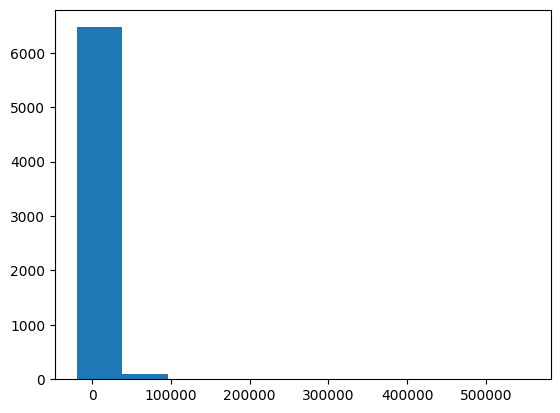

In [545]:
# @title Histrogams of Sales

plt.figure()
plt.hist(data=df,x='sales')
plt.show()

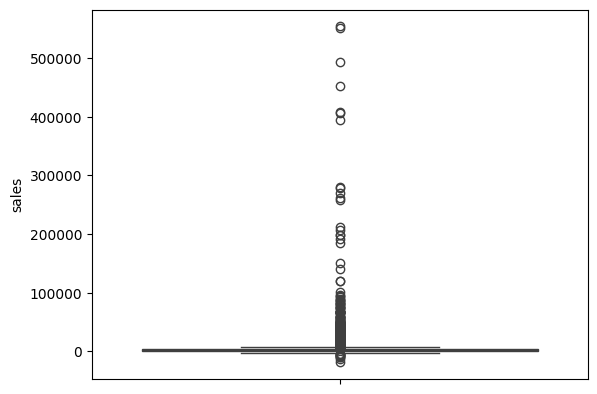

In [546]:
# @title Boxplot of Sales

plt.figure()
sns.boxplot(data=df['sales'])
plt.show()

In [547]:
# @title Correlation Analysis
df.corr()

,date,customer,sales,no_of_products
date,1.000000,0.207449,-0.024260,0.063218
customer,0.207449,1.000000,0.028538,-0.013639
sales,-0.024260,0.028538,1.000000,0.301551
no_of_products,0.063218,-0.013639,0.301551,1.000000


In [548]:
#df.reset_index(inplace=True)
df.head()

,date,customer,sales,no_of_products
0,2023-01-02,8687,982.75,3
1,2023-01-03,8687,2753.00,9
2,2023-01-04,8687,1456.26,4
3,2023-01-05,8687,1147.25,4
4,2023-01-06,8687,552.75,1


In [549]:
# Creating funciton to add Time Series Features in given Data Frame
def add_time_series_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df.reset_index(inplace=True)
    #df['year_month'] = df['date'].dt.to_period('M')
    #df['year_month'] = df['date'].dt.to_timestamp()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    #df['quarter'] = df['date'].dt.quarter
    #df['dayofweek'] = df['date'].dt.dayofweek
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    df.set_index('date', inplace=True)
    #df.drop('index',axis=1,inplace=True)
    #X = df[['dayofweek','quarter','month','year',
           #'dayofyear','dayofmonth']]
    #if label:
     #   y = df[label]
      #  return X, y
    return df

In [550]:
# Adding Time Series Features in data frame
df = add_time_series_features(df,None)

In [551]:
df.head()

,index,customer,sales,no_of_products,year,month
date,,,,,,
2023-01-02,0,8687,982.75,3,2023,1
2023-01-03,1,8687,2753.00,9,2023,1
2023-01-04,2,8687,1456.26,4,2023,1
2023-01-05,3,8687,1147.25,4,2023,1
2023-01-06,4,8687,552.75,1,2023,1


In [552]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6586 entries, 2023-01-02 to 2024-12-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           6586 non-null   int64  
 1   customer        6586 non-null   int64  
 2   sales           6586 non-null   float64
 3   no_of_products  6586 non-null   int64  
 4   year            6586 non-null   int32  
 5   month           6586 non-null   int32  
dtypes: float64(1), int32(2), int64(3)
memory usage: 308.7 KB


In [553]:
def add_lag_features (df):
    df['lag_1'] = df.groupby('customer')['sales'].shift(1)
    df['lag_2'] = df.groupby('customer')['sales'].shift(2)
    df['lag_3'] = df.groupby('customer')['sales'].shift(3)
    df['rolling_mean_3'] = df.groupby('customer')['sales'].rolling(window=3).mean().iloc[-1]
    return df

In [554]:
df = add_lag_features(df)

In [555]:
df.head()


,index,customer,sales,no_of_products,year,month,lag_1,lag_2,lag_3,rolling_mean_3
date,,,,,,,,,,
2023-01-02,0,8687,982.75,3,2023,1,NaN,NaN,NaN,10853.806667
2023-01-03,1,8687,2753.00,9,2023,1,982.75,NaN,NaN,10853.806667
2023-01-04,2,8687,1456.26,4,2023,1,2753.00,982.75,NaN,10853.806667
2023-01-05,3,8687,1147.25,4,2023,1,1456.26,2753.00,982.75,10853.806667
2023-01-06,4,8687,552.75,1,2023,1,1147.25,1456.26,2753.00,10853.806667


In [556]:
df.count()

index             6586
customer          6586
sales             6586
no_of_products    6586
year              6586
month             6586
lag_1             6484
lag_2             6384
lag_3             6284
rolling_mean_3    6586
dtype: int64

# Train a model using XGBoost ML

In [557]:
# split train and test data from df
split_date = '2024-10-01'
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [558]:
x_train = train_df.drop(columns='sales')
y_train = train_df['sales']
x_test = test_df.drop(columns='sales')
y_test = test_df['sales']

In [559]:
x_train.head()


,index,customer,no_of_products,year,month,lag_1,lag_2,lag_3,rolling_mean_3
date,,,,,,,,,
2023-01-02,0,8687,3,2023,1,NaN,NaN,NaN,10853.806667
2023-01-03,1,8687,9,2023,1,982.75,NaN,NaN,10853.806667
2023-01-04,2,8687,4,2023,1,2753.00,982.75,NaN,10853.806667
2023-01-05,3,8687,4,2023,1,1456.26,2753.00,982.75,10853.806667
2023-01-06,4,8687,1,2023,1,1147.25,1456.26,2753.00,10853.806667


In [560]:
y_train.head()

date
2023-01-02     982.75
2023-01-03    2753.00
2023-01-04    1456.26
2023-01-05    1147.25
2023-01-06     552.75
Name: sales, dtype: float64

In [561]:
x_test.head()

,index,customer,no_of_products,year,month,lag_1,lag_2,lag_3,rolling_mean_3
date,,,,,,,,,
2024-10-08,129,10000863,3,2024,10,1795.0,4302.5,1122.5,10853.806667
2024-10-09,130,10000863,6,2024,10,2555.5,1795.0,4302.5,10853.806667
2024-10-21,131,10000863,3,2024,10,8770.0,2555.5,1795.0,10853.806667
2024-10-30,132,10000863,1,2024,10,3107.5,8770.0,2555.5,10853.806667
2024-11-05,133,10000863,1,2024,11,853.0,3107.5,8770.0,10853.806667


In [562]:
print(y_test.head())

date
2024-10-08    2555.5
2024-10-09    8770.0
2024-10-21    3107.5
2024-10-30     853.0
2024-11-05    3159.0
Name: sales, dtype: float64


### Feature Importances 
<p> Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of week was most commonly used to split trees, while day of the month and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits. <p>

In [563]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
    
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(eval_metric="mae"),
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error', # Use negative MAE for optimization
                           cv=3, # Cross-validation folds
                           verbose=2,
                           n_jobs=-1
                           ) # Use all available cores

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best negative MAE found: ", grid_search.best_score_)

# Update the regressor with the best parameters
reg_tuned = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best negative MAE found:  -5026.7786745008625


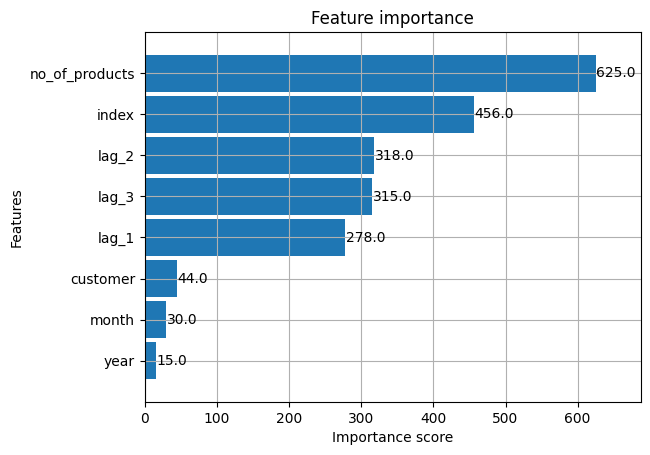

In [564]:
_ = plot_importance(reg_tuned, height=0.9)

In [566]:
test_df['sales_prediction'] = reg_tuned.predict(x_test)
df_all = pd.concat([test_df,train_df], sort=False)

In [568]:
df4 = test_df[test_df['customer'] == 10000863]

df4

,index,customer,sales,no_of_products,year,month,lag_1,lag_2,lag_3,rolling_mean_3,sales_prediction
date,,,,,,,,,,,
2024-10-08,129,10000863,2555.50,3,2024,10,1795.00,4302.50,1122.50,10853.806667,3445.145508
2024-10-09,130,10000863,8770.00,6,2024,10,2555.50,1795.00,4302.50,10853.806667,8937.286133
2024-10-21,131,10000863,3107.50,3,2024,10,8770.00,2555.50,1795.00,10853.806667,6175.726562
2024-10-30,132,10000863,853.00,1,2024,10,3107.50,8770.00,2555.50,10853.806667,4265.709961
2024-11-05,133,10000863,3159.00,1,2024,11,853.00,3107.50,8770.00,10853.806667,3087.210938
2024-11-11,134,10000863,2151.00,3,2024,11,3159.00,853.00,3107.50,10853.806667,3164.968018
2024-11-21,135,10000863,3124.00,3,2024,11,2151.00,3159.00,853.00,10853.806667,3445.145508
2024-11-22,136,10000863,5365.25,5,2024,11,3124.00,2151.00,3159.00,10853.806667,4604.625000
2024-12-05,137,10000863,1227.00,2,2024,12,5365.25,3124.00,2151.00,10853.806667,4694.977051


In [569]:
test_df.head()

,index,customer,sales,no_of_products,year,month,lag_1,lag_2,lag_3,rolling_mean_3,sales_prediction
date,,,,,,,,,,,
2024-10-08,129,10000863,2555.5,3,2024,10,1795.0,4302.5,1122.5,10853.806667,3445.145508
2024-10-09,130,10000863,8770.0,6,2024,10,2555.5,1795.0,4302.5,10853.806667,8937.286133
2024-10-21,131,10000863,3107.5,3,2024,10,8770.0,2555.5,1795.0,10853.806667,6175.726562
2024-10-30,132,10000863,853.0,1,2024,10,3107.5,8770.0,2555.5,10853.806667,4265.709961
2024-11-05,133,10000863,3159.0,1,2024,11,853.0,3107.5,8770.0,10853.806667,3087.210938


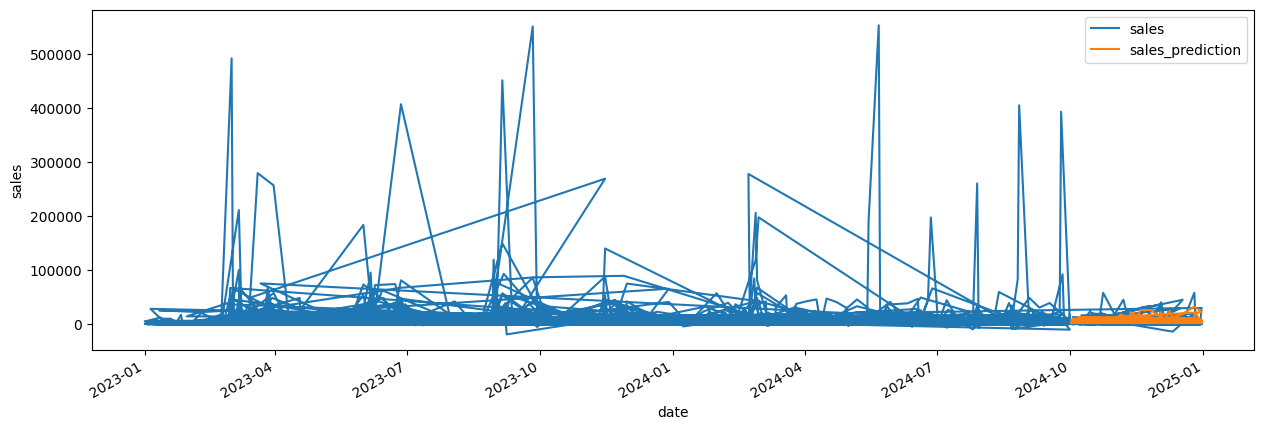

In [570]:
_ = df_all[['sales','sales_prediction']].plot(figsize=(15, 5))
#plt.title('Sales and Tuned Model Predictions Over Time')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

In [571]:

# Train the model
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [572]:
# Predict future sales
predictions = model.predict(x_test)

In [573]:
# Evaluate performance
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 3212.48
Root Mean Squared Error (RMSE): 77155555.93
R-squared (R²): -1.69


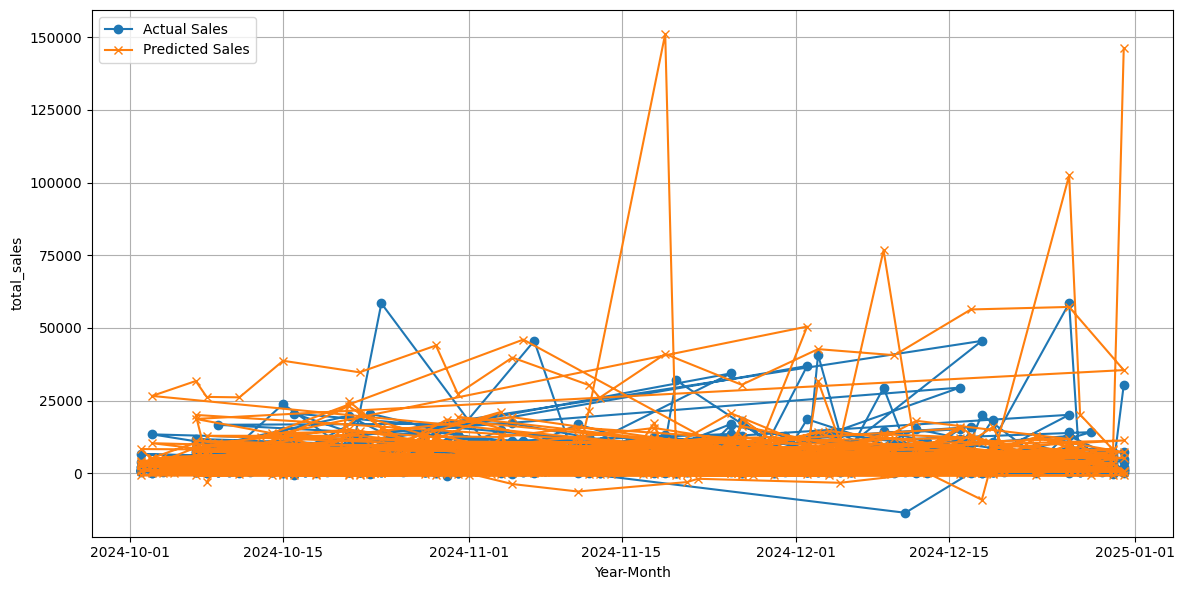

In [574]:
# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', marker='o')
plt.plot(y_test.index, predictions, label='Predicted Sales', marker='x')
#plt.title('Actual vs Predicted Sales')
plt.xlabel('Year-Month')
plt.ylabel('total_sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()